# Hyper Parameter Optimization Example Using Petrophysical Modeling with Amazon SageMaker XGBoost algorithm
_**Single machine training for regression with Amazon SageMaker XGBoost algorithm**_

---

---
## Contents
1. [Introduction](#Introduction)
2. [Setup](#Setup)
  1. [Fetching the dataset](#Fetching-the-dataset)
  2. [Data Ingestion](#Data-ingestion)
3. [Hyper Parameter Optimization](#Hyper-Parameter-Optimization)  
4. [Training the XGBoost model](#Training-the-XGBoost-model)
5. [Set up hosting for the model](#Set-up-hosting-for-the-model)
  1. [Import model into hosting](#Import-model-into-hosting)
  2. [Create endpoint configuration](#Create-endpoint-configuration)
  3. [Create endpoint](#Create-endpoint)
6. [Validate the model for use](#Validate-the-model-for-use)

---
## Introduction

This notebook demonstrates the use of Amazon SageMaker's implementation of the XGBoost algorithm Hyper Parameter Optimization to train and host a regression model for prediction of porosity from other well log measurements. 

> A Jupyter Notebook is an open-source web application that allows you to create and share documents that contain live code, equations, visualizations and narrative text. - http://jupyter.org/

The dataset is log data from nine wells, with 5 wireline log measurements, two indicator variables and a facies label at half foot intervals. The seven predictor variables are:

Five wireline log curves including: 

- Gamma ray (GR)
- Resistivity logging (ILD_log10)
- Photoelectric effect (PE) - Note, some wells do not have PE.
- Neutron-density porosity difference 
- Average neutron-density porosity (DeltaPHI and PHIND)

Two geologic constraining variables: 

- Nonmarine-marine indicator (NM_M) 
- Relative position (RELPOS)

We will focus on these logs: GR, ILD_log10, DeltaPH, PHIND, where we try to predict PHIND by training using 7 wells, 1 validation well, and one well for blind test. 

The dataset comes from a class exercise from The University of Kansas on Neural Networks and Fuzzy Systems. This exercise is based on a consortium project to use machine learning techniques to create a reservoir model of the largest gas fields in North America, the Hugoton and Panoma Fields. For more info on the origin of the data, see Bohling and Dubois (2003) and Dubois et al. (2007).

---
## Setup


This notebook was created and tested on an ml.m4.4xlarge notebook instance.

Let's start by specifying:
1. The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
1. The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [47]:
%%time

import os
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()
region = boto3.Session().region_name

# bucket='mef-test' # put your s3 bucket name here, and create s3 bucket
# # prefix = 'mehdi-test/high-level'
# prefix = 'public-data-example/high-level'


bucket='hpo-testing-mehdi' # put your s3 bucket name here, and create s3 bucket
prefix = 'xgb-hpo-poro-regression'

bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket)

CPU times: user 40 ms, sys: 4 ms, total: 44 ms
Wall time: 58 ms


In [94]:
import smhpolib
import boto3
region = boto3.Session().region_name
print (region)
smhpo = smhpolib.get_smhpo_client(region)


tuning_job_name = 'xgb-hpo-poro-regression5' # customize with your tuning job name

us-east-1
Using SMHPO_ENDPOINT_URL: https://86b5tsckyb.execute-api.us-east-1.amazonaws.com/Prod


### Hyper Parameter Optimization

Here we go through different steps involved in HPO. Please note that this is a new product and may not be available to public by the time you are using this! Please contact a AWS contact person for help.

In [95]:
####################################################################################
####      TUNING     ##############################################################
####################################################################################


####################################################################################
####      IMPORTANT !!!!!!!!!!!!    ######################################

# CHANGE METRIC (auc, rmse ,...) in all places (4-5) and also make sure to change 
# Maximize or Minimize accourding to the criteria (auc: Maximize, rmse:Minimize)

####################################################################################

tuning_job_config = {
    "ParameterRanges": {
        "CategoricalParameterRanges": [],
      "ContinuousParameterRanges": [
        {
          "MaxValue": "1",
          "MinValue": "0",
          "Name": "eta",
          "Type": "Continuous"
}, {
          "MaxValue": "10",
          "MinValue": "0",
          "Name": "gamma",
          "Type": "Continuous"
}, {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "min_child_weight",
          "Type": "Continuous"
} ],
      "IntegerParameterRanges": [
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "max_depth",
          "Type": "Integer"
} ]
    },
    "ResourceLimits": {
      "MaxNumberOfTrainingJobs": 10,
      "MaxParallelTrainingJobs": 3
    },
    "Strategy": "Bayesian",
    "TuningJobObjective": {
      "MetricName": "valid-rmse",
      "Type": "Minimize"
    }
}

In [96]:
####################################################################################
####      Training     ##############################################################
####################################################################################


containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'}
training_image = containers[region]
training_job_definition = {
    "AlgorithmSpecification": {
      "MetricDefinitions": [
        {
          "Name": "valid-rmse",
          "Regex": "validation-[a-z]+:([0-9\\.]+)"
        },
        {
          "Name": "train-rmse",
          "Regex": "train-[a-z]+:([0-9\\.]+)"
        }
      ],
      "TrainingImage": training_image,
      "TrainingInputMode": "File"
    },
    "InputDataConfig": [
      {
        "ChannelName": "train",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": bucket_path + "/" + prefix + '/train'

} }
}, {
        "ChannelName": "validation",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": bucket_path + "/" + prefix + '/validation'
} }
} ],
    "OutputDataConfig": {
      "S3OutputPath": "s3://{}".format(bucket)
    },
    "ResourceConfig": {
      "InstanceCount": 1,
      "InstanceType": "ml.c4.2xlarge",
      "VolumeSizeInGB": 10
    },
    "RoleArn": role,
    "StaticHyperParameters": {
      "eval_metric": "rmse",
      "num_round": "100",
      "objective": "reg:linear",
      "rate_drop": "0.3",
      "tweedie_variance_power": "1.4"
    },
    "StoppingCondition": {
      "MaxRuntimeInSeconds": 43200
    }
}

In [97]:
####################################################################################
####      Launch tuning/training   #################################################
####################################################################################

smhpo.create_tuning_job(TuningJobName = tuning_job_name,
                    TuningJobConfig = tuning_job_config,
                    TrainingJobDefinition = training_job_definition)

{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
   'content-length': '95',
   'content-type': 'application/json',
   'date': 'Fri, 13 Apr 2018 20:36:06 GMT',
   'via': '1.1 c8b22b813bc9140f3fc38a5e2fae3685.cloudfront.net (CloudFront)',
   'x-amz-apigw-id': 'FTAscEGXIAMFfeg=',
   'x-amz-cf-id': '0Zy2XUqo6su6YnkLIZqueDFDSx5gwQpvrO5VU8wOkFpvGXh5sfin9g==',
   'x-amzn-requestid': '4a45448b-3f5a-11e8-b30d-8d5f69a11f35',
   'x-amzn-trace-id': 'sampled=0;root=1-5ad114b6-1cd58e1ab297bf3370e54868',
   'x-cache': 'Miss from cloudfront'},
  'HTTPStatusCode': 200,
  'RequestId': '4a45448b-3f5a-11e8-b30d-8d5f69a11f35',
  'RetryAttempts': 0},
 'TuningJobArn': 'arn:aws:sagemaker:us-east-1:597844091762:tuning-job/xgb-hpo-poro-regression5'}

In [118]:
#####################################################################################
####        MONITOR JOB      #################################################
####################################################################################

smhpo.describe_tuning_job(TuningJobName =tuning_job_name)

{'BestTrainingJob': {'FinalTuningJobObjectiveMetric': {'MetricName': 'valid-rmse',
   'Value': 3.20352},
  'HyperParameters': {'eta': '0.048607529603813975',
   'eval_metric': 'rmse',
   'gamma': '1.2329359559052957',
   'max_depth': '2',
   'min_child_weight': '5.294569737212162',
   'num_round': '100',
   'objective': 'reg:linear',
   'rate_drop': '0.3',
   'tweedie_variance_power': '1.4'},
  'RetriedAttempt': 1,
  'TrainingJobName': 'xgb-hpo-poro-regression5-008-8bd2fe79',
  'TrainingJobStatus': 'Completed'},
 'LastModifiedTime': datetime.datetime(2018, 4, 13, 20, 57, 25, tzinfo=tzlocal()),
 'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
   'content-length': '2651',
   'content-type': 'application/json',
   'date': 'Fri, 13 Apr 2018 20:58:36 GMT',
   'via': '1.1 dbdd67063f01c39bd9e0f02db8431258.cloudfront.net (CloudFront)',
   'x-amz-apigw-id': 'FTD_ZE_tIAMF19w=',
   'x-amz-cf-id': 'r8Vcdg1yECzTqQJ7ZPt6Hruc1-1cGpDJKiIwYoWPqKeQ2lqBhRX4SA==',
   'x-amzn-requestid': '

In [103]:
#####################################################################################
####        GET THE TRAINING JOB NAME FROM HERE      ################################
####################################################################################


list_training_result = print(smhpo.list_training_jobs_for_tuning_job(TuningJobName=tuning_job_name, MaxResults=100))

{'ResponseMetadata': {'RequestId': 'a8ada9ff-3f5a-11e8-997b-151e71eb83eb', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/json', 'content-length': '1092', 'connection': 'keep-alive', 'date': 'Fri, 13 Apr 2018 20:38:44 GMT', 'x-amzn-requestid': 'a8ada9ff-3f5a-11e8-997b-151e71eb83eb', 'x-amz-apigw-id': 'FTBFMGfMoAMFRDA=', 'x-amzn-trace-id': 'sampled=0;root=1-5ad11554-2d7bed5986e458ff9c1fff94', 'x-cache': 'Miss from cloudfront', 'via': '1.1 c8b22b813bc9140f3fc38a5e2fae3685.cloudfront.net (CloudFront)', 'x-amz-cf-id': 'tjPxU06ClFdCFR1EoH3H7a_HBCI9PNem1H2-jEJU_zMchR477sjLOw=='}, 'RetryAttempts': 0}, 'TrainingJobSummaries': [{'TrainingJobName': 'xgb-hpo-poro-regression5-003-4d68c2a1', 'TrainingJobStatus': 'InProgress', 'RetriedAttempt': 0, 'HyperParameters': {'eta': '0.8013502439628606', 'eval_metric': 'rmse', 'tweedie_variance_power': '1.4', 'max_depth': '10', 'num_round': '100', 'gamma': '2.070187574440965', 'min_child_weight': '6.986570582976296', 'objective': 'reg:li

In [38]:
list_training_result = print(smhpo.list_training_jobs_for_tuning_job(TuningJobName=tuning_job_name, MaxResults=1))

{'ResponseMetadata': {'RequestId': 'afa1fcad-3f37-11e8-b609-89593f190249', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/json', 'content-length': '909', 'connection': 'keep-alive', 'date': 'Fri, 13 Apr 2018 16:28:23 GMT', 'x-amzn-requestid': 'afa1fcad-3f37-11e8-b609-89593f190249', 'x-amz-apigw-id': 'FScaNFU_oAMFhTg=', 'x-amzn-trace-id': 'sampled=0;root=1-5ad0daa7-26b147b5696f49439422562a', 'x-cache': 'Miss from cloudfront', 'via': '1.1 fd885dc16612d4e9d70f328fd0542052.cloudfront.net (CloudFront)', 'x-amz-cf-id': '1k5wyVVjlxJe_xRlvVcDLQyN06FzIsuJjUBktxOYvI9b98T1f5c9gg=='}, 'RetryAttempts': 0}, 'TrainingJobSummaries': [{'TrainingJobName': 'xgb-hpo-poro-regression2-007-ee21ab7c', 'TrainingJobStatus': 'Stopped', 'RetriedAttempt': 0, 'HyperParameters': {'eta': '0.833010894471637', 'eval_metric': 'auc', 'tweedie_variance_power': '1.4', 'max_depth': '2', 'num_round': '100', 'gamma': '4.828420324601', 'min_child_weight': '4.0877493128247835', 'objective': 'reg:linear', 'r

In [108]:
#####################################################################################
####                         DE-BUGGING             ################################
####################################################################################

sagemaker = boto3.client('sagemaker')
sagemaker.describe_training_job(TrainingJobName='xgb-hpo-poro-regression5-003-4d68c2a1')


{'AlgorithmSpecification': {'TrainingImage': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
  'TrainingInputMode': 'File'},
 'CreationTime': datetime.datetime(2018, 4, 13, 20, 36, 17, 213000, tzinfo=tzlocal()),
 'HyperParameters': {'eta': '0.8013502439628606',
  'eval_metric': 'rmse',
  'gamma': '2.070187574440965',
  'max_depth': '10',
  'min_child_weight': '6.986570582976296',
  'num_round': '100',
  'objective': 'reg:linear',
  'rate_drop': '0.3',
  'tweedie_variance_power': '1.4'},
 'InputDataConfig': [{'ChannelName': 'train',
   'CompressionType': 'None',
   'ContentType': 'csv',
   'DataSource': {'S3DataSource': {'S3DataDistributionType': 'FullyReplicated',
     'S3DataType': 'S3Prefix',
     'S3Uri': 'https://s3-us-east-1.amazonaws.com/hpo-testing-mehdi/xgb-hpo-poro-regression/train'}},
   'RecordWrapperType': 'None'},
  {'ChannelName': 'validation',
   'CompressionType': 'None',
   'ContentType': 'csv',
   'DataSource': {'S3DataSource': {'S3DataDistributionType'

In [19]:
####################################################################################
####      STPO      #################################################
####################################################################################

smhpo.stop_tuning_job(TuningJobName=tuning_job_name)

{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
   'content-length': '0',
   'content-type': 'application/json',
   'date': 'Fri, 13 Apr 2018 16:06:13 GMT',
   'via': '1.1 a2a3d7501713013e8b54a236e17fb3be.cloudfront.net (CloudFront)',
   'x-amz-apigw-id': 'FSZKKFYgIAMFcIg=',
   'x-amz-cf-id': '5Fiwk7nXaCsAGEPn16FbHbCLj-1CtGcGqdn84obSXHErcb63X14WHw==',
   'x-amzn-requestid': '95fcec18-3f34-11e8-9d1e-e70edeeb048b',
   'x-amzn-trace-id': 'sampled=0;root=1-5ad0d574-1d268f26fc89a8ac6ff16c33',
   'x-cache': 'Miss from cloudfront'},
  'HTTPStatusCode': 200,
  'RequestId': '95fcec18-3f34-11e8-9d1e-e70edeeb048b',
  'RetryAttempts': 0}}

### Fetching the dataset

Following methods split the data into train/test/validation datasets and upload files to S3.

In [43]:
%%time

import io
import boto3
import random

def data_split(FILE_DATA, FILE_TRAIN, FILE_VALIDATION, FILE_TEST, Valid_Well_Name, Blind_Well_Name, TARGET_VAR):
    data = pd.read_csv(FILE_DATA)
    n = data.shape[0]
    
    # Make the first column the target feature    
    cols = data.columns.tolist()
    target_pos = data.columns.get_loc(TARGET_VAR)
    cols.pop(target_pos)
    cols = [TARGET_VAR] + cols
    data = data.loc[:,cols]
                
    # Remove target colun from test set
    #test_data = test_data.drop([TARGET_VAR], axis=1)

    # Split data
    test_data = data[data['Well Name'] == Blind_Well_Name]
    test_data = test_data.drop(['Well Name'], axis=1)
    
    valid_data = data[data['Well Name'] == Valid_Well_Name]
    valid_data = valid_data.drop(['Well Name'], axis=1)

    train_data = data[data['Well Name'] != Blind_Well_Name]
    train_data = train_data[train_data['Well Name'] != Valid_Well_Name]

    train_data = train_data.drop(['Well Name'], axis=1)

    train_data.to_csv(FILE_TRAIN, index=False, header=False)
    valid_data.to_csv(FILE_VALIDATION, index=False, header=False)
    test_data.to_csv(FILE_TEST, index=False, header=False)
    
def write_to_s3(fobj, bucket, key):
    return boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_fileobj(fobj)

# def upload_to_s3(bucket, channel, filename):
#     fobj=open(filename, 'rb')
#     key = prefix+'/'+channel+'/'+filename
#     url = 's3://{}/{}'.format(bucket, key)
#     print('Writing to {}'.format(url))
#     write_to_s3(fobj, bucket, key)
#     return(url)


def upload_to_s3(bucket, channel, filename):
    fobj=open(filename, 'rb')
    key = prefix+'/'+channel+'/'+filename
    url = 's3://{}/{}'.format(bucket, key)
    print('Writing to {}'.format(url))
    write_to_s3(fobj, bucket, key)     
    return(url)


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 28.4 µs


### Data ingestion

Next, we read the dataset from the existing repository into memory, for preprocessing prior to training. This processing could be done *in situ* by Amazon Athena, Apache Spark in Amazon EMR, Amazon Redshift, etc., assuming the dataset is present in the appropriate location. Then, the next step would be to transfer the data to S3 for use in training. For small datasets, such as this one, reading into memory isn't onerous, though it would be for larger datasets.

When using the csv option, here is the critical piece of information about the data format:

> For CSV training, the algorithm assumes that the target variable is in the first column and that the CSV does not have a header record. For CSV inference, the algorithm assumes that CSV input does not have the label column.

[Source](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html)

In [44]:
# Remove non-numeric columns
import pandas as pd
data = pd.read_csv('facies_vectors.csv')
# Remove rows with missing values
data.dropna(inplace=True)

data['Well Name'].unique()
data = data.loc[:,['Well Name', 'GR', 'ILD_log10', 'DeltaPHI', 'PHIND']]


# Write file back to disk
data.to_csv('facies_num.csv', index=False)

In [45]:
FILE_DATA = 'facies_num.csv'
TARGET_VAR = 'PHIND'
FILE_TRAIN = 'facies_train.csv'
FILE_VALIDATION = 'facies_validation.csv'
FILE_TEST = 'facies_test.csv'
Valid_Well_Name = 'SHRIMPLIN'
Blind_Well_Name = 'SHANKLE'

data_split(FILE_DATA, FILE_TRAIN, FILE_VALIDATION, FILE_TEST, Valid_Well_Name, Blind_Well_Name, TARGET_VAR)

In [46]:
# upload the files to the S3 bucket
s3_train_loc = upload_to_s3(bucket = bucket, channel = 'train', filename = FILE_TRAIN)
s3_valid_loc = upload_to_s3(bucket = bucket, channel = 'validation', filename = FILE_VALIDATION)
s3_test_loc = upload_to_s3(bucket = bucket, channel = 'test', filename = FILE_TEST)

Writing to s3://hpo-testing-mehdi/xgb-hpo-poro-regression/train/facies_train.csv
Writing to s3://hpo-testing-mehdi/xgb-hpo-poro-regression/validation/facies_validation.csv
Writing to s3://hpo-testing-mehdi/xgb-hpo-poro-regression/test/facies_test.csv


## Training the XGBoost model

After setting training parameters, we kick off training, and poll for status until training is completed, which in this example, takes between 5 and 6 minutes.

XGBoost hyperparameter [docs](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html).

In [119]:
import sagemaker

#   'HyperParameters': {'eta': '0.048607529603813975',
#    'eval_metric': 'rmse',
#    'gamma': '1.2329359559052957',
#    'max_depth': '2',
#    'min_child_weight': '5.294569737212162',
#    'num_round': '100',
#    'objective': 'reg:linear',
#    'rate_drop': '0.3',
#    'tweedie_variance_power': '1.4'},
        
# Instantiate the estimator
xgboost = sagemaker.estimator.Estimator('811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path='s3://{}/{}/output'.format(bucket, prefix),
                                       sagemaker_session=sagemaker.Session())

# Set the hyperparameters
xgboost.set_hyperparameters(max_depth=2,
                        eta=0.048607529603813975,
                        gamma=1.2329359559052957,
                        min_child_weight=5.294569737212162,
                        subsample=0.8,
                        silent=0,
                        objective='reg:linear',
                        num_round=100)

# Set the input data formatting and locatiopns
s3_input_train = sagemaker.s3_input(s3_data=s3_train_loc, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=s3_valid_loc, content_type='csv')

# Train the model
xgboost.fit({'train': s3_input_train, 'validation': s3_input_validation})

INFO:sagemaker:Creating training-job with name: xgboost-2018-04-13-21-25-46-918


..........................................................
Arguments: train
[2018-04-13:21:30:26:INFO] Running standalone xgboost training.
[2018-04-13:21:30:26:INFO] File size need to be processed in the node: 0.07mb. Available memory size in the node: 78.0mb
/opt/amazon/lib/python2.7/site-packages/sage_xgboost/train_helper.py:315: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(os.path.join(files_path, csv_file), sep=None, header=None)
[21:30:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]#011train-rmse:14.3483#011validation-rmse:12.2532
[21:30:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1]#011train-rmse:13.7738#011validation-rmse:11.7146
[21:30:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 ex

===== Job Complete =====
Billable seconds: 136


In [120]:
xgboost_predictor = xgboost.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2018-04-13-21-51-39-593
INFO:sagemaker:Creating endpoint with name xgboost-2018-04-13-21-25-46-918


--------------------------------------------------------------------------!

## Validate the model for use
Finally, the customer can now validate the model for use. They can obtain the endpoint from the client library using the result from previous operations, and generate classifications from the trained model using that endpoint.


In [121]:
from sagemaker.predictor import csv_serializer

## import numpy as np

def predict(data, rows=500):
    xgboost_predictor.content_type = 'text/csv'
    xgboost_predictor.serializer = csv_serializer
    xgboost_predictor.deserializer = None

    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgboost_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

test_data = pd.read_csv(FILE_TEST, header=None)
labels = test_data.iloc[:,0]
predictions = predict(test_data.as_matrix()[:, 1:]) # Note that we are not using the first column, which is the label

In [122]:
import numpy as np

# def predict(data, rows=500):
def predict(data):
    rows=len(data)
    xgboost_predictor.content_type = 'text/csv'
    xgboost_predictor.serializer = csv_serializer
    xgboost_predictor.deserializer = None

    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgboost_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

test_data = pd.read_csv(FILE_TEST, header=None)
labels = test_data.iloc[:,0]
predictions = predict(test_data.as_matrix()[:, 1:]) # Note that we are not using the first column, which is the label

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,PPoro
937,2,A1 SH,SHANKLE,2774.5,98.36,0.642,-0.1,18.685,2.9,1,1.000,17.656174
938,2,A1 SH,SHANKLE,2775.0,97.57,0.631,7.9,16.745,3.2,1,0.984,14.321953
939,2,A1 SH,SHANKLE,2775.5,98.41,0.615,12.8,14.105,3.2,1,0.968,14.665792
940,2,A1 SH,SHANKLE,2776.0,85.92,0.597,13.0,13.385,3.4,1,0.952,14.665792
941,2,A1 SH,SHANKLE,2776.5,83.16,0.592,12.3,13.345,3.4,1,0.935,14.665792


Correlation coeficient = 0.85109 
Mean Squared Error = 25.97263


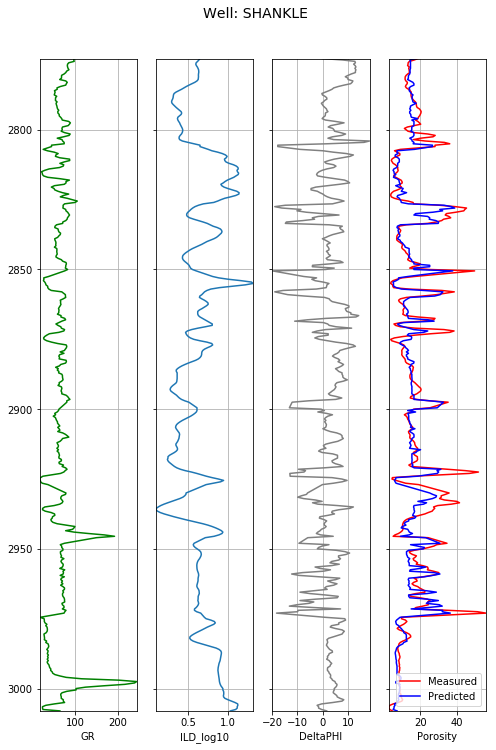

In [124]:

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import mean_squared_error

def log_plot(logs):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')

    ztop=logs.Depth.min(); zbot=logs.Depth.max()
        
    f, ax = plt.subplots(nrows=1, ncols=4, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[3].plot(logs.PPoro, logs.Depth, '-', color='blue')
    ax[3].legend(['Measured','Predicted'])
    
    for i in range(len(ax)):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("Porosity")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())

    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)


    
data = pd.read_csv('facies_vectors.csv')
Blindwell = data[data['Well Name'] == Blind_Well_Name]
Blindwell['PPoro'] = predictions
display(Blindwell.head())
log_plot(Blindwell)
print('Correlation coeficient = {0:.5f} \nMean Squared Error = {1:.5f}'.format(
    np.corrcoef(predictions,labels)[0,1]
    , mean_squared_error(predictions,labels)))

### (Optional) Delete the Endpoint
If you're ready to be done with this notebook, make sure run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [11]:
print(xgboost_predictor.endpoint)

import sagemaker
sagemaker.Session().delete_endpoint(xgboost_predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: xgboost-2018-02-22-18-49-36-562


xgboost-2018-02-22-18-49-36-562
